In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


In [2]:
%pip -q install git+https://github.com/iseedeep/deeprage.git@main
from deeprage.core import val_pie, val_bar, val_all_hist, compare_columns

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')

In [4]:
df_train.drop('id',axis=1,inplace=True)
test_id = df_test['id']
df_test.drop('id', axis=1, inplace=True)

In [5]:
df_train

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP
...,...,...,...,...,...,...,...,...,...
749995,25,69,30,Clayey,Maize,8,16,6,28-28
749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17
749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26
749998,31,68,29,Red,Cotton,9,11,12,20-20


In [6]:
df_train.dtypes

Temparature         int64
Humidity            int64
Moisture            int64
Soil Type          object
Crop Type          object
Nitrogen            int64
Potassium           int64
Phosphorous         int64
Fertilizer Name    object
dtype: object

In [7]:
df_train.shape, df_test.shape

((750000, 9), (250000, 8))

In [8]:
df_train.isna().sum()

Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

In [9]:
df_test.isna().sum()

Temparature    0
Humidity       0
Moisture       0
Soil Type      0
Crop Type      0
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64

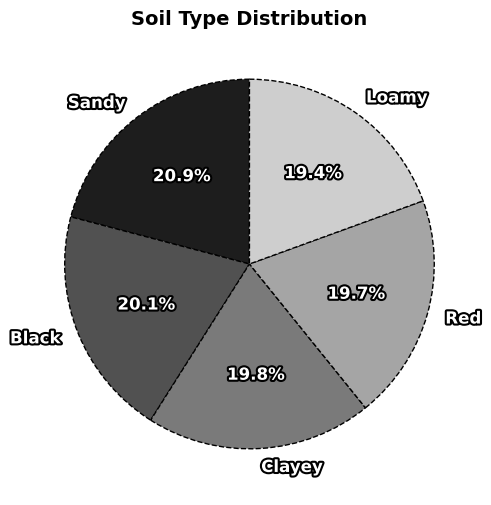

FixedFormatter should only be used together with FixedLocator


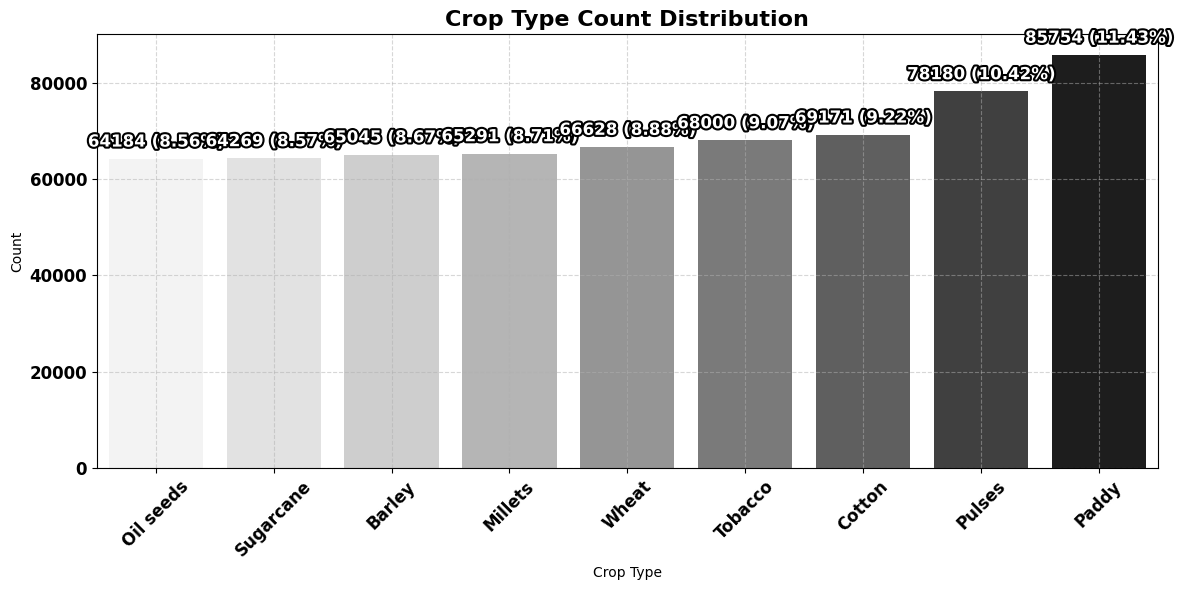

In [10]:
val_pie(df_train, 'Soil Type')
val_bar(df_train, 'Crop Type')

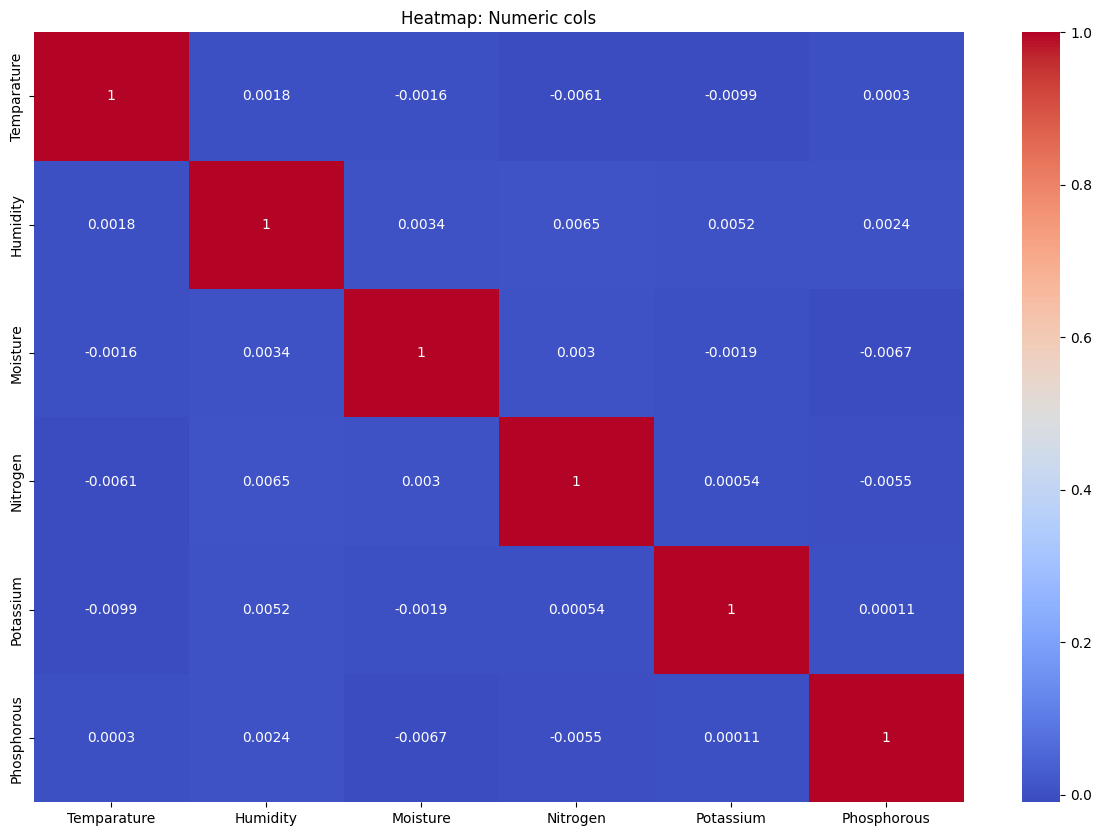

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Heatmap: Numeric cols')
plt.show()

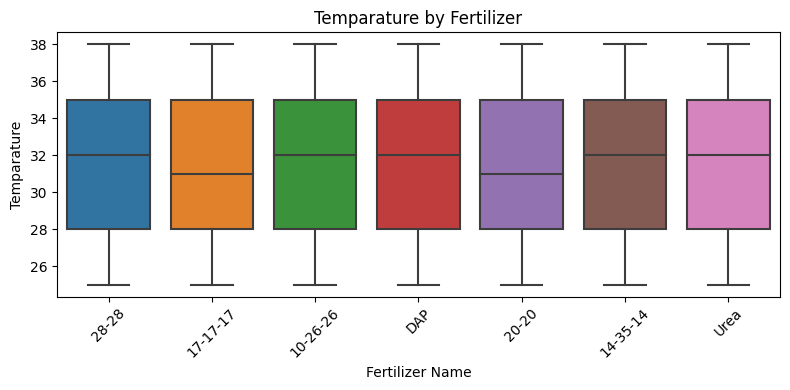

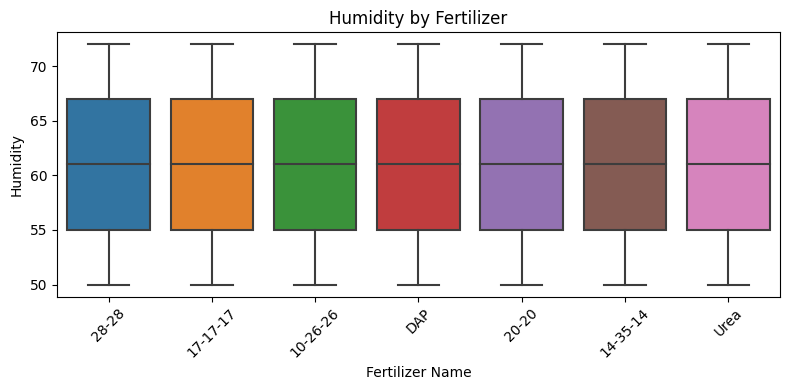

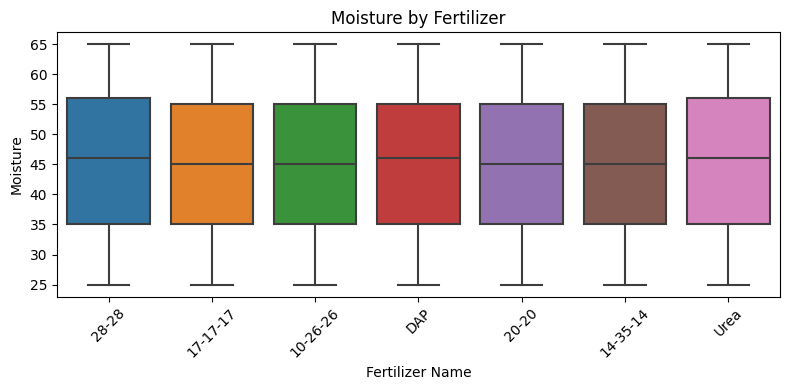

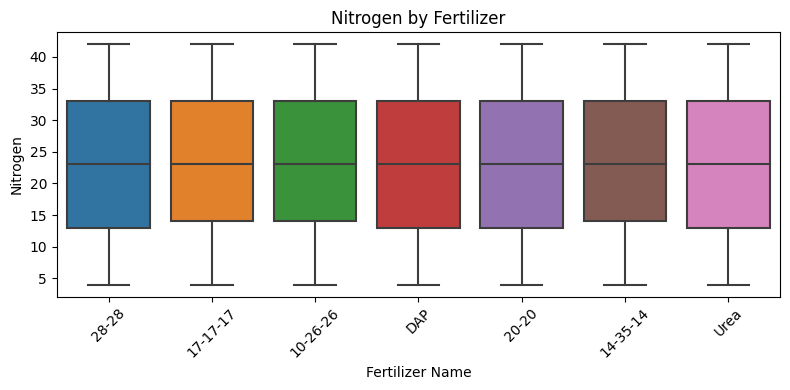

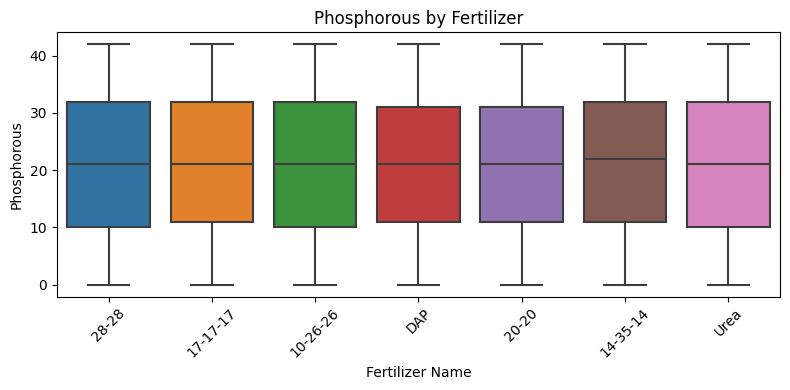

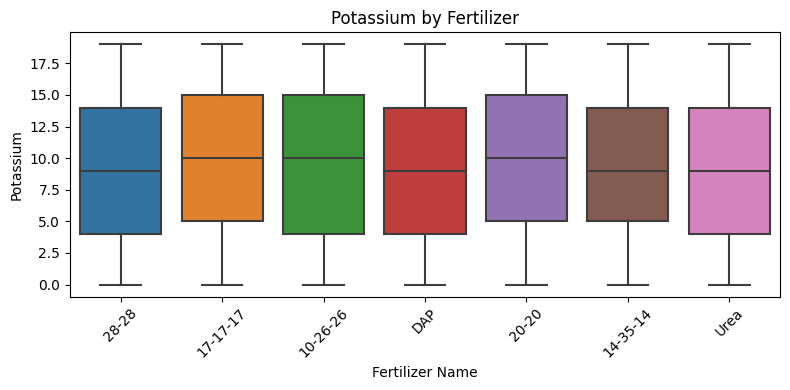

In [12]:
for col in ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Phosphorous', 'Potassium']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_train, x='Fertilizer Name', y=col)
    plt.title(f'{col} by Fertilizer')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_soil = LabelEncoder()
le_crop = LabelEncoder()

le.fit(df_train['Fertilizer Name'])
le_soil.fit(pd.concat([df_train['Soil Type'], df_test['Soil Type']]))
le_crop.fit(pd.concat([df_train['Crop Type'], df_test['Crop Type']]))

df_train['Soil Type'] = le_soil.transform(df_train['Soil Type'])
df_train['Crop Type'] = le_crop.transform(df_train['Crop Type'])
df_train['Fertilizer Name'] = le.transform(df_train['Fertilizer Name'])
df_test['Soil Type'] = le_soil.transform(df_test['Soil Type'])
df_test['Crop Type'] = le_crop.transform(df_test['Crop Type'])

feature_cols = [
    'Soil Type', 'Crop Type',
    'Temparature', 'Humidity', 'Moisture',
    'Nitrogen', 'Potassium', 'Phosphorous'
]

In [14]:
X = df_train.drop('Fertilizer Name', axis=1)
y = df_train['Fertilizer Name']
X_test = df_test[feature_cols]

In [15]:
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

"""
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': len(le.classes_),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'verbosity': -1,
        'n_jobs': -1,
        'seed': 42
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    accs = []
    for train_idx, valid_idx in cv.split(X, y):
        dtrain = lgb.Dataset(X.iloc[train_idx], label=y[train_idx])
        dvalid = lgb.Dataset(X.iloc[valid_idx], label=y[valid_idx])
        model = lgb.train(params, dtrain, valid_sets=[dvalid], num_boost_round=100)
        preds = np.argmax(model.predict(X.iloc[valid_idx]), axis=1)
        accs.append(accuracy_score(y[valid_idx], preds))
    return np.mean(accs)
"""

"\ndef objective(trial):\n    params = {\n        'objective': 'multiclass',\n        'num_class': len(le.classes_),\n        'metric': 'multi_logloss',\n        'boosting_type': 'gbdt',\n        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),\n        'num_leaves': trial.suggest_int('num_leaves', 16, 64),\n        'max_depth': trial.suggest_int('max_depth', 4, 12),\n        'verbosity': -1,\n        'n_jobs': -1,\n        'seed': 42\n    }\n    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)\n    accs = []\n    for train_idx, valid_idx in cv.split(X, y):\n        dtrain = lgb.Dataset(X.iloc[train_idx], label=y[train_idx])\n        dvalid = lgb.Dataset(X.iloc[valid_idx], label=y[valid_idx])\n        model = lgb.train(params, dtrain, valid_sets=[dvalid], num_boost_round=100)\n        preds = np.argmax(model.predict(X.iloc[valid_idx]), axis=1)\n        accs.append(accuracy_score(y[valid_idx], preds))\n    return np.mean(accs)\n"

In [16]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=10)
#best_params = study.best_params

[I 2025-06-26 16:37:50,313] A new study created in memory with name: no-name-7b35dad1-6139-46ef-9369-d1fa385d72cd
[I 2025-06-26 16:39:26,464] Trial 0 finished with value: 0.192684 and parameters: {'learning_rate': 0.19240521505690011, 'num_leaves': 56, 'max_depth': 6}. Best is trial 0 with value: 0.192684.
[I 2025-06-26 16:40:50,597] Trial 1 finished with value: 0.18912933333333334 and parameters: {'learning_rate': 0.12811326422288105, 'num_leaves': 43, 'max_depth': 5}. Best is trial 0 with value: 0.192684.
[I 2025-06-26 16:41:55,336] Trial 2 finished with value: 0.18616 and parameters: {'learning_rate': 0.26587078440676665, 'num_leaves': 35, 'max_depth': 11}. Best is trial 0 with value: 0.192684.
[I 2025-06-26 16:43:00,075] Trial 3 finished with value: 0.187832 and parameters: {'learning_rate': 0.22452792676969516, 'num_leaves': 27, 'max_depth': 8}. Best is trial 0 with value: 0.192684.
[I 2025-06-26 16:44:13,641] Trial 4 finished with value: 0.184512 and parameters: {'learning_rate': 0.0910944607921546, 'num_leaves': 20, 'max_depth': 8}. Best is trial 0 with value: 0.192684.
[I 2025-06-26 16:45:19,982] Trial 5 finished with value: 0.18409466666666666 and parameters: {'learning_rate': 0.28381708741878825, 'num_leaves': 55, 'max_depth': 12}. Best is trial 0 with value: 0.192684.
[I 2025-06-26 16:46:39,760] Trial 6 finished with value: 0.18396666666666664 and parameters: {'learning_rate': 0.07546795214904603, 'num_leaves': 22, 'max_depth': 12}. Best is trial 0 with value: 0.192684.
[I 2025-06-26 16:47:51,396] Trial 7 finished with value: 0.18507600000000002 and parameters: {'learning_rate': 0.10253451425842722, 'num_leaves': 18, 'max_depth': 8}. Best is trial 0 with value: 0.192684.
[I 2025-06-26 16:49:13,064] Trial 8 finished with value: 0.19035866666666668 and parameters: {'learning_rate': 0.20336208829651053, 'num_leaves': 54, 'max_depth': 7}. Best is trial 0 with value: 0.192684.
[I 2025-06-26 16:50:23,198] Trial 9 finished with value: 0.18747599999999998 and parameters: {'learning_rate': 0.1867290313070475, 'num_leaves': 35, 'max_depth': 11}. Best is trial 0 with value: 0.192684.

In [17]:
best_params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1924,
    'num_leaves': 56,
    'max_depth': 6,
    'seed': 42
}

In [18]:
train_data = lgb.Dataset(X, label=y)
final_model = lgb.train(
    best_params,
    train_data,
    num_boost_round=100,
    callbacks=[lgb.log_evaluation(10)]
)

In [19]:
preds = final_model.predict(X_test)
top_3_preds = np.argsort(preds, axis=1)[:, -3:][:, ::-1]

In [20]:
top_3_labels = [le.inverse_transform(row) for row in top_3_preds]
submission_labels = [' '.join(map(str, labels)) for labels in top_3_labels]

In [21]:
submission = pd.DataFrame({
    'id': test_id,
    'Fertilizer Name': submission_labels
})
submission.to_csv('submission.csv', index=False)

In [22]:
submission

,id,Fertilizer Name
0,750000,14-35-14 28-28 10-26-26
1,750001,14-35-14 10-26-26 28-28
2,750002,10-26-26 17-17-17 14-35-14
3,750003,14-35-14 17-17-17 DAP
4,750004,20-20 28-28 17-17-17
...,...,...
249995,999995,28-28 10-26-26 17-17-17
249996,999996,10-26-26 28-28 20-20
249997,999997,14-35-14 17-17-17 10-26-26
249998,999998,28-28 10-26-26 14-35-14
